# InstructIR ✏️🖼️
## High-Quality Image Restoration Following Human Instructions

[Marcos V. Conde](https://scholar.google.com/citations?user=NtB1kjYAAAAJ&hl=en), [Gregor Geigle](https://scholar.google.com/citations?user=uIlyqRwAAAAJ&hl=en), [Radu Timofte](https://scholar.google.com/citations?user=u3MwH5kAAAAJ&hl=en)


Original Code and Material: [https://github.com/mv-lab/InstructIR](https://github.com/mv-lab/InstructIR)

<a href="https://github.com/mv-lab/InstructIR"><img src="https://i.ibb.co/Xp5bJ7n/instructir-teaser.png" alt="InstructIR" border="0"></a>

<br>

> **Abstract:** Image restoration is a fundamental problem that involves recovering a high-quality clean image from its degraded observation. All-In-One image restoration models can effectively restore images from various types and levels of degradation using degradation-specific information as prompts to guide the restoration model. In this work, we present the first approach that uses human-written instructions to guide the image restoration model. Given natural language prompts, our model can recover high-quality images from their degraded counterparts, considering multiple degradation types. Our method, InstructIR, achieves state-of-the-art results on several restoration tasks including image denoising, deraining, deblurring, dehazing, and (low-light) image enhancement. InstructIR improves +1dB over previous all-in-one restoration methods. Moreover, our dataset and results represent a novel benchmark for new research on text-guided image restoration and enhancement.

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random

from utils import *
from models import instructir

from text.models import LanguageModel, LMHead

SEED=42
seed_everything(SEED=SEED)
torch.backends.cudnn.deterministic = True

Check the config file at `configs/eval5d.yml` for more context.

In [3]:
CONFIG     = "configs/eval5d.yml"
USE_WANDB  = False
LM_MODEL   = "models/lm_instructir-7d.pt"
MODEL_NAME = "models/im_instructir-7d.pt"

# parse config file
with open(os.path.join(CONFIG), "r") as f:
    config = yaml.safe_load(f)

cfg = dict2namespace(config)

Create the InstructIR model using the provided pre-trained weights at `models/`.
- You will need to load the image model `im_`
- and the language model `lm_`

In [4]:

print ("Creating InstructIR")
model = instructir.create_model(input_channels =cfg.model.in_ch, width=cfg.model.width, enc_blks = cfg.model.enc_blks, 
                            middle_blk_num = cfg.model.middle_blk_num, dec_blks = cfg.model.dec_blks, txtdim=cfg.model.textdim)

################### LOAD IMAGE MODEL

assert MODEL_NAME, "Model weights required for evaluation"

print ("IMAGE MODEL CKPT:", MODEL_NAME)
model.load_state_dict(torch.load(MODEL_NAME), strict=True)

nparams   = count_params (model)
print ("Loaded weights!", nparams / 1e6)

Creating InstructIR
IMAGE MODEL CKPT: models/im_instructir-7d.pt
Loaded weights! 15.843363


In [5]:
################### LANGUAGE MODEL

if cfg.model.use_text:
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

    # Initialize the LanguageModel class
    LMODEL = cfg.llm.model
    language_model = LanguageModel(model=LMODEL)
    lm_head = LMHead(embedding_dim=cfg.llm.model_dim, hidden_dim=cfg.llm.embd_dim, num_classes=cfg.llm.nclasses)
    lm_head = lm_head #.to(device)
    lm_nparams   = count_params (lm_head)

    print ("LMHEAD MODEL CKPT:", LM_MODEL)
    lm_head.load_state_dict(torch.load(LM_MODEL), strict=True)
    print ("Loaded weights!")

else:
    LMODEL = None
    language_model = None
    lm_head = None
    lm_nparams = 0

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


LMHEAD MODEL CKPT: models/lm_instructir-7d.pt
Loaded weights!


# Running InstructIR! 

In [6]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [7]:
def process_img (image, prompt):
    """
    Given an image and a prompt, we run InstructIR to restore the image following the human prompt.
    image: RGB image as numpy array normalized to [0,1]
    prompt: plain python string,

    returns the restored image as numpy array.
    """

    # Convert the image to tensor
    y = torch.Tensor(image).permute(2,0,1).unsqueeze(0)

    # Get the text embedding (and predicted degradation class)
    lm_embd = language_model(prompt)
    lm_embd = lm_embd #.to(device)
    text_embd, deg_pred = lm_head (lm_embd)

    # Forward pass: Paper Figure 2
    x_hat = model(y, text_embd)

    # convert the restored image <x_hat> into a np array
    restored_img = x_hat[0].permute(1,2,0).cpu().detach().numpy()
    restored_img = np.clip(restored_img, 0. , 1.)
    return restored_img

You need to feed into the function and RGB image and a simple instruction (string).

Check `load_img` from `utils.py` we just use PIL to load a given image.
You can find more sample images in `images/`

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


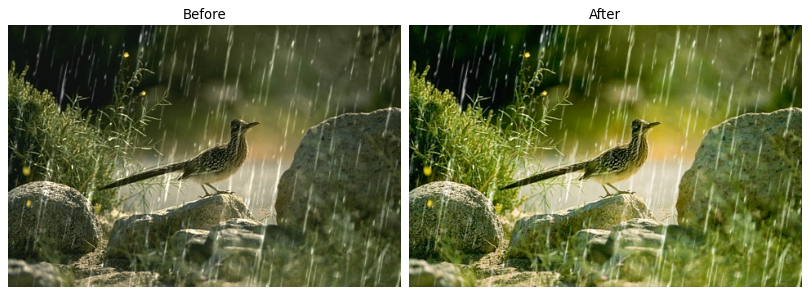

In [8]:
IMG    = "images/rain-020.png" 
PROMPT = "Retouch the picture as a professional photographer please"

image = load_img(IMG)
restored_image = process_img(image, PROMPT )
# save_rgb (restored_image, "result.png") # save the resultant image
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))

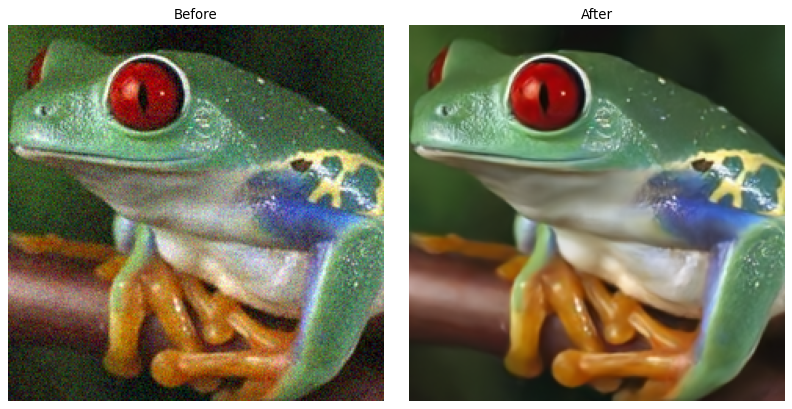

In [9]:
IMG    = "images/frog.png" # from RealSRSet
PROMPT = "Can you remove the little dots in the image? is very unpleasant"

image = load_img(IMG)
restored_image = process_img(image, PROMPT )
# save_rgb (restored_image, "result.png") # save the resultant image
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))

### Control the process

Sometimes the blur, rain, or film grain noise are pleasant effects and part of the **"aesthetics"**.

Here we show a simple example on how to interact with InstructIR 
> Disclaimer: please remember this is not a product, thus, you will notice some limitations.

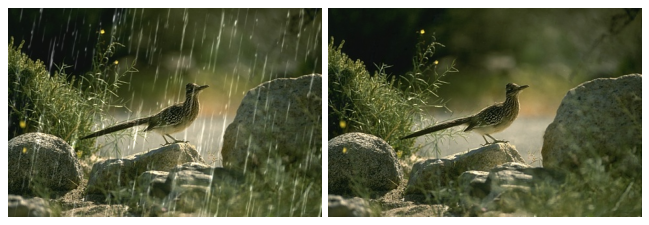

In [10]:
IMG    = "images/rain-020.png"
image  = load_img(IMG)

PROMPT1 = "I love this photo, could you remove the raindrops? please keep the content intact"
result1 = process_img(image, PROMPT1 )
plot_all([image, result1], figsize=(8,4))

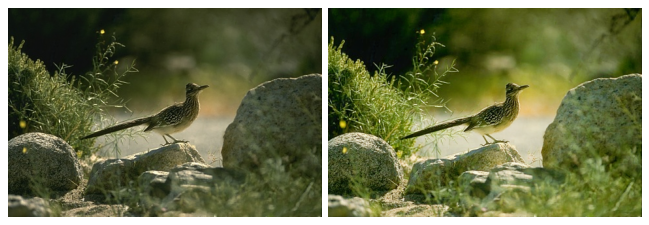

In [11]:
PROMPT2 = "Can you make it look stunning? like a professional photo"
result2 = process_img(result1, PROMPT2 )
plot_all([result1, result2], figsize=(8,4))

The final result looks indeed stunning :)

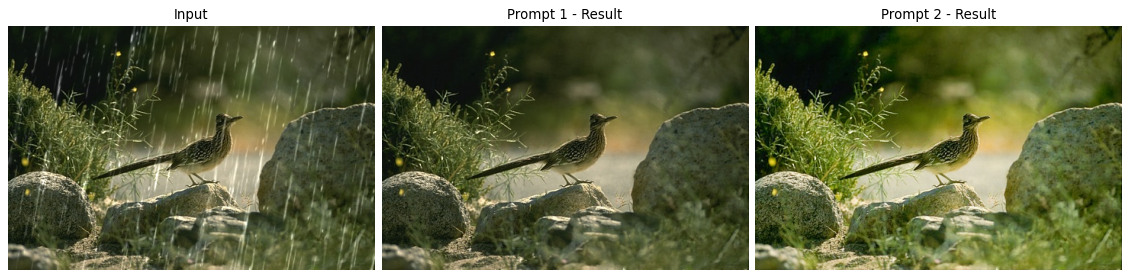

In [13]:
plot_all([image, result1, result2], names=["Input", "Prompt 1 - Result", "Prompt 2 - Result"], figsize=(14,7))